#CM4709 Computer Vision
#Lab 09 Time Series Prediction Using LSTM

Note: This lab is based on the [Youtube video here](https://youtu.be/c0k-YLQGKjY).

##Aims
* Use the Tensorflow LSTM library/model to predict a time series.

##Downloading Dataset

The [Jena climate dataset](https://keras.io/examples/timeseries/timeseries_weather_forecasting/) is a time series that consists of 14 features like temperature, pressure, humidity, etc.
We will use the dataset to predict temperature only.
The data set is huge, with data recorded every 10 minutes for 8 years from 2009 to 2016.

The following code (adapted from the Youtube video) download the dataset:

In [1]:
import tensorflow as tf
import os

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
print(csv_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
/root/.keras/datasets/jena_climate_2009_2016_extracted


Alternatively, you can use the following shell commands to download and unzip the dataset.
The path to the CSV file will be different, but it is fine as far as the `csv_path` value is set correctly:

In [2]:
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip
csv_path='jena_climate_2009_2016.csv'

--2025-04-30 09:17:18--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 142.251.175.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  7.36MB/s    in 1.8s    

2025-04-30 09:17:21 (7.36 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


##Exploring the Dataset

The following codes read the CSV file into a dataframe and dump out the data:

In [3]:
import pandas as pd

df_original=pd.read_csv(csv_path)
df_original

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


The dataset is huge, as data were logged with 10 minutes for 8 years.
We do not need such a high resolution sampling, and will only take data at every hour.
The following code will get data from the original dataframe from row 5, and every 6 rows. This will be the data at every hour:


In [4]:
df=df_original[5::6]
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,31.12.2016 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
420527,31.12.2016 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
420533,31.12.2016 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
420539,31.12.2016 22:10:00,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7


We will now set the dataframe index to be the timestamp, with a different format:

In [5]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
2009-01-01 06:00:00,01.01.2009 06:00:00,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0
2009-01-01 07:00:00,01.01.2009 07:00:00,998.33,-9.17,264.12,-10.10,92.9,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.8
2009-01-01 08:00:00,01.01.2009 08:00:00,999.17,-8.10,265.12,-9.05,92.8,3.31,3.07,0.24,1.92,3.08,1311.65,0.72,1.25,213.9
2009-01-01 09:00:00,01.01.2009 09:00:00,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,0.34,0.63,202.2


To get the temperature column and plot it:

<Axes: xlabel='Date Time'>

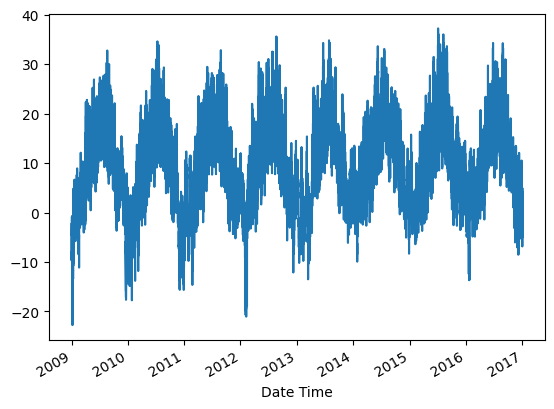

In [6]:
temp = df['T (degC)']
temp.plot()

##Prepare Input and Label

To predict the temperature at time t, we will use the 5 previous temperature data at time t-5, t-4, t-3, t-2 and t-1.
We need to reshape our temperature column value into the correct shape.

In [8]:
import numpy as np

# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_x_y(df, window_size=5):
  df_as_np = df.to_numpy()
  x = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    x.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(x), np.array(y)

In [9]:
WINDOW_SIZE = 5
x1, y1 = df_to_x_y(temp, WINDOW_SIZE)
print('x shape: ',x1.shape)
print('y shape: ',y1.shape)
print('===X===')
print(x1[:5])
print('===Y===')
print(y1[:5])

x shape:  (70086, 5, 1)
y shape:  (70086,)
===X===
[[[-8.05]
  [-8.88]
  [-8.81]
  [-9.05]
  [-9.63]]

 [[-8.88]
  [-8.81]
  [-9.05]
  [-9.63]
  [-9.67]]

 [[-8.81]
  [-9.05]
  [-9.63]
  [-9.67]
  [-9.17]]

 [[-9.05]
  [-9.63]
  [-9.67]
  [-9.17]
  [-8.1 ]]

 [[-9.63]
  [-9.67]
  [-9.17]
  [-8.1 ]
  [-7.66]]]
===Y===
[-9.67 -9.17 -8.1  -7.66 -7.04]


##Training, Validation, and Testing Datasets

We will split the dataset into training, validation, and testing.

In [10]:
#take 1st 60000 entries as training data
x_train1, y_train1 = x1[:60000], y1[:60000]

#next 5000 entries as validation data
x_val1, y_val1 = x1[60000:65000], y1[60000:65000]

#the rest as testing data
x_test1, y_test1 = x1[65000:], y1[65000:]

#print shapes of all subsets
print('x_train shape: ',x_train1.shape)
print('y_train shape: ', y_train1.shape)
print('x_val shape: ',x_val1.shape)
print('y_val shape: ',y_val1.shape)
print('x_test shape:',x_test1.shape)
print('y_test shape:', y_test1.shape)

x_train shape:  (60000, 5, 1)
y_train shape:  (60000,)
x_val shape:  (5000, 5, 1)
y_val shape:  (5000,)
x_test shape: (5086, 5, 1)
y_test shape: (5086,)


##Creating the LSTM Model

We can now create the LSTM model.
The process is similar to how we create other NN.
Note the use of the [`LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/) layer.
Notice the shape of the input and output layers.

Also note that LSTM is keeping memory of the whole sequence. So the output is not only dependent on the input values at an instance, but all previous inputs.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

##Compile & Train Model

Training of the model is quite standard.
We add a callback to create a checkpoint that saves the best model during validation.

In [13]:
#callback for saving best model during training
cp1 = ModelCheckpoint('best_model.keras', save_best_only=True)

#compile model
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

#train model
model1.fit(x_train1, y_train1, validation_data=(x_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 84.4583 - root_mean_squared_error: 8.9505 - val_loss: 1.4792 - val_root_mean_squared_error: 1.2162
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.6695 - root_mean_squared_error: 1.9057 - val_loss: 0.6755 - val_root_mean_squared_error: 0.8219
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1.2060 - root_mean_squared_error: 1.0973 - val_loss: 0.5548 - val_root_mean_squared_error: 0.7449
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.8062 - root_mean_squared_error: 0.8977 - val_loss: 0.5258 - val_root_mean_squared_error: 0.7251
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7135 - root_mean_squared_error: 0.8446 - val_loss: 0.5241 - val_root_mean_squared_error: 0.7239
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6771 - root_mean_squared_error: 0.8228 - val_loss: 0.4955 - val_root_mean_squared_error: 0.7039
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━

##Prediction vs Actual in Training Dataset

In most cases we won't do this as the model is trained using the training data. It should perform well on this.

In [14]:
from tensorflow.keras.models import load_model

#load the best model
model1 = load_model('best_model.keras')

In [15]:
#do predict on training data
train_predictions = model1.predict(x_train1).flatten()

#print prediction vs actual
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


,Train Predictions,Actuals
0,-9.976739,-9.67
1,-9.801953,-9.17
2,-8.852929,-8.10
3,-7.308325,-7.66
4,-7.150074,-7.04
...,...,...
59995,5.964618,6.07
59996,7.255480,9.88
59997,12.205763,13.53
59998,16.175097,15.43


##Plot Prediction vs Actual in Training Dataset

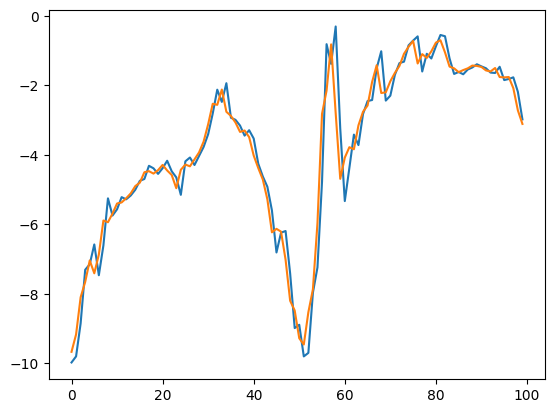

In [16]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][:100])
plt.plot(train_results['Actuals'][:100])


##Prediction vs Actual in Validation Dataset

In [17]:
val_predictions = model1.predict(x_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Val Predictions,Actuals
0,15.463513,14.02
1,13.171070,13.67
2,12.994438,12.27
3,11.483505,11.19
4,10.337003,10.85
...,...,...
4995,17.383936,18.27
4996,17.395645,17.85
4997,17.235247,16.65
4998,15.851384,15.85


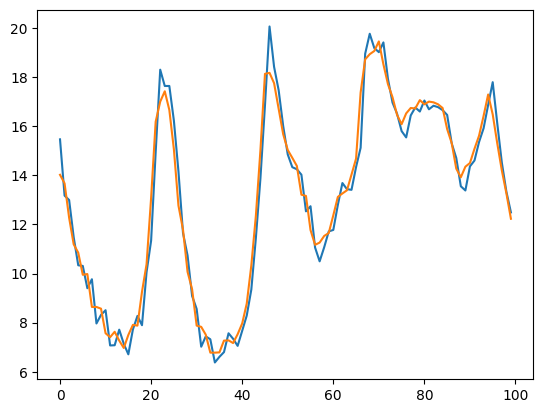

In [18]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

##Prediction vs Actual in Testing Dataset

In [19]:
test_predictions = model1.predict(x_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Test Predictions,Actuals
0,14.392145,13.99
1,13.230606,13.46
2,12.833391,12.93
3,12.445919,12.43
4,11.995646,12.17
...,...,...
5081,-0.886435,-0.98
5082,-1.282566,-1.40
5083,-1.701305,-2.75
5084,-3.184464,-2.89


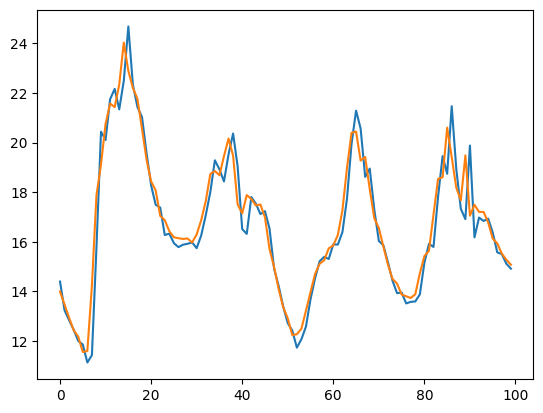

In [20]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

##Other Prediction Techniques

If you are interested to go further, there is a [Part 2 of the Youtube video](https://youtu.be/kGdbPnMCdOg) which uses other techniques like GRU and 1d CNN.